# Global Vectors for Word Representation (GloVe)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Load Datasets

In [3]:
class GloveDataset:
    
    def __init__(self, text, n_words=200000, window_size=5):
        
        self._window_size = window_size
        self._tokens = text.split(' ')[:n_words]
        word_counter = Counter()
        word_counter.update(self._tokens)
        
        self._word2idx = {w:i for i, (w, _) in enumerate(word_counter.most_common())}
        self._idx2word = {i:w for w, i in self._word2idx.items()}
        self._vocab_len = len(self._word2idx)
        self._id_tokens = [self._word2idx[w] for w in self._tokens]
        self._create_coocurrence_matrix()
        
        print('Total of words: {}'.format(len(self._tokens)))
        print('Vocabulary length: {}'.format(self._vocab_len))
        
    def _create_coocurrence_matrix(self):
        
        co_matrix = defaultdict(Counter)
        for i, w in enumerate(self._id_tokens):
            start_i = max(i - self._window_size, 0)
            end_i = min(i + self._window_size + 1, len(self._id_tokens))
            for j in range(start_i, end_i):
                if i != j:
                    c = self._id_tokens[j]
                    co_matrix[w][c] += 1 / abs(j-i)
        
        self._i_idx = list()
        self._j_idx = list()
        self._xij = list()
        
        # create indexes and x values tensors
        for w, co in co_matrix.items():
            for c, v in co.items():
                self._i_idx.append(w)
                self._j_idx.append(c)
                self._xij.append(v)
        
        self._i_idx = torch.LongTensor(self._i_idx)
        self._j_idx = torch.LongTensor(self._j_idx)
        self._xij = torch.FloatTensor(self._xij)
    
    def get_batches(self, batch_size):
        # generate random idx
        random_idx = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))
        
        for p in range(0, len(random_idx), batch_size):
            batch_idx = random_idx[p:p+batch_size]
            yield self._xij[batch_idx], self._i_idx[batch_idx], self._j_idx[batch_idx]

In [4]:
datasets = GloveDataset(open('./datasets/text8').read(), 10000000)

Total of words: 10000000
Vocabulary length: 189075


## Set Configs

In [5]:
LR = 0.05
N_EPOCHS = 10 # try 100 to get much better results

BATCH_SIZE = 2048
EMBEDDING_DIM = 300
X_MAX = 100
ALPHA = 0.75

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

## Build [Glove](https://nlp.stanford.edu/pubs/glove.pdf) Network

In [7]:
class Glove(nn.Module):
    
    def __init__(self, input_size, embedding_dim):
        super(Glove, self).__init__()
        
        self.vocab_size = input_size
        
        self.wi = nn.Embedding(self.vocab_size, embedding_dim)
        self.wj = nn.Embedding(self.vocab_size, embedding_dim)
        self.bi = nn.Embedding(self.vocab_size, 1)
        self.bj = nn.Embedding(self.vocab_size, 1)
        
        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()
        
    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()
        
        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j
        
        return x

#### Initialize Glove Network

In [8]:
glove = Glove(datasets._vocab_len, EMBEDDING_DIM)
glove.to(device)

Glove(
  (wi): Embedding(189075, 300)
  (wj): Embedding(189075, 300)
  (bi): Embedding(189075, 1)
  (bj): Embedding(189075, 1)
)

## Set Loss Function

In [9]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    loss = torch.mean(loss)
    
    return loss

In [10]:
def weight_loss(x, x_max, alpha):
    wx = (x/x_max) ** alpha
    wx = torch.min(wx, torch.ones_like(wx))
    
    return wx

## Set Optimizer

In [11]:
optimizer = torch.optim.Adagrad(glove.parameters(), lr=LR)

## Train Glove Network

In [12]:
print_every = 100
train_losses = []

glove.train()
for epoch in range(N_EPOCHS):
    
    batch_i = 0
    for x_ij, i_idx, j_idx in datasets.get_batches(BATCH_SIZE):
        
        batch_i += 1
        
        x_ij = x_ij.to(device)
        i_idx = i_idx.to(device)
        j_idx = j_idx.to(device)

        optimizer.zero_grad()
        outputs = glove(i_idx, j_idx)
        weights = weight_loss(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights, outputs, torch.log(x_ij))
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if batch_i % print_every == 0:
            print('Epoch: {}/{}, '.format(epoch, N_EPOCHS),
                  'Batch: {}/{}, '.format(batch_i, int(len(datasets._xij) / BATCH_SIZE)),
                  'Train Loss: {}'.format(np.mean(train_losses[-20:])))
    
    print('Saving model...')
    if not os.path.exists('./weights/'): os.makedirs('./weights/')
    torch.save(glove.state_dict(), 'weights/glove_text8.pt')

Epoch: 0/10,  Batch: 100/10726,  Train Loss: 1.1153456270694733
Epoch: 0/10,  Batch: 200/10726,  Train Loss: 1.0644996523857118
Epoch: 0/10,  Batch: 300/10726,  Train Loss: 0.9968386828899384
Epoch: 0/10,  Batch: 400/10726,  Train Loss: 0.9244718164205551
Epoch: 0/10,  Batch: 500/10726,  Train Loss: 0.9279677420854568
Epoch: 0/10,  Batch: 600/10726,  Train Loss: 0.9035448759794236
Epoch: 0/10,  Batch: 700/10726,  Train Loss: 0.8904357552528381
Epoch: 0/10,  Batch: 800/10726,  Train Loss: 0.891763636469841
Epoch: 0/10,  Batch: 900/10726,  Train Loss: 0.8765872716903687
Epoch: 0/10,  Batch: 1000/10726,  Train Loss: 0.8505554914474487
Epoch: 0/10,  Batch: 1100/10726,  Train Loss: 0.8058260411024094
Epoch: 0/10,  Batch: 1200/10726,  Train Loss: 0.7877869188785553
Epoch: 0/10,  Batch: 1300/10726,  Train Loss: 0.7920207947492599
Epoch: 0/10,  Batch: 1400/10726,  Train Loss: 0.8029113292694092
Epoch: 0/10,  Batch: 1500/10726,  Train Loss: 0.7535289615392685
Epoch: 0/10,  Batch: 1600/10726,  T

Epoch: 1/10,  Batch: 2000/10726,  Train Loss: 0.24088973924517632
Epoch: 1/10,  Batch: 2100/10726,  Train Loss: 0.23932767137885094
Epoch: 1/10,  Batch: 2200/10726,  Train Loss: 0.24125945791602135
Epoch: 1/10,  Batch: 2300/10726,  Train Loss: 0.23656829372048377
Epoch: 1/10,  Batch: 2400/10726,  Train Loss: 0.24072256460785865
Epoch: 1/10,  Batch: 2500/10726,  Train Loss: 0.23911233842372895
Epoch: 1/10,  Batch: 2600/10726,  Train Loss: 0.23537251800298692
Epoch: 1/10,  Batch: 2700/10726,  Train Loss: 0.23537929877638816
Epoch: 1/10,  Batch: 2800/10726,  Train Loss: 0.23599310144782065
Epoch: 1/10,  Batch: 2900/10726,  Train Loss: 0.23762249946594238
Epoch: 1/10,  Batch: 3000/10726,  Train Loss: 0.23596714362502097
Epoch: 1/10,  Batch: 3100/10726,  Train Loss: 0.23667628988623618
Epoch: 1/10,  Batch: 3200/10726,  Train Loss: 0.23405973315238954
Epoch: 1/10,  Batch: 3300/10726,  Train Loss: 0.23172928616404534
Epoch: 1/10,  Batch: 3400/10726,  Train Loss: 0.2381960079073906
Epoch: 1/10

Epoch: 2/10,  Batch: 3800/10726,  Train Loss: 0.14517828971147537
Epoch: 2/10,  Batch: 3900/10726,  Train Loss: 0.14648161232471466
Epoch: 2/10,  Batch: 4000/10726,  Train Loss: 0.14829171299934388
Epoch: 2/10,  Batch: 4100/10726,  Train Loss: 0.14688270092010497
Epoch: 2/10,  Batch: 4200/10726,  Train Loss: 0.14689847454428673
Epoch: 2/10,  Batch: 4300/10726,  Train Loss: 0.14740530997514725
Epoch: 2/10,  Batch: 4400/10726,  Train Loss: 0.14832355156540872
Epoch: 2/10,  Batch: 4500/10726,  Train Loss: 0.146705262362957
Epoch: 2/10,  Batch: 4600/10726,  Train Loss: 0.1463702991604805
Epoch: 2/10,  Batch: 4700/10726,  Train Loss: 0.1445878863334656
Epoch: 2/10,  Batch: 4800/10726,  Train Loss: 0.1450440354645252
Epoch: 2/10,  Batch: 4900/10726,  Train Loss: 0.1470474436879158
Epoch: 2/10,  Batch: 5000/10726,  Train Loss: 0.1452922835946083
Epoch: 2/10,  Batch: 5100/10726,  Train Loss: 0.1453754149377346
Epoch: 2/10,  Batch: 5200/10726,  Train Loss: 0.14248571097850798
Epoch: 2/10,  Batc

Epoch: 3/10,  Batch: 5600/10726,  Train Loss: 0.10944608747959136
Epoch: 3/10,  Batch: 5700/10726,  Train Loss: 0.10867089480161667
Epoch: 3/10,  Batch: 5800/10726,  Train Loss: 0.10762203969061375
Epoch: 3/10,  Batch: 5900/10726,  Train Loss: 0.1071916587650776
Epoch: 3/10,  Batch: 6000/10726,  Train Loss: 0.10784789584577084
Epoch: 3/10,  Batch: 6100/10726,  Train Loss: 0.10745110101997853
Epoch: 3/10,  Batch: 6200/10726,  Train Loss: 0.10686819143593311
Epoch: 3/10,  Batch: 6300/10726,  Train Loss: 0.10475688129663467
Epoch: 3/10,  Batch: 6400/10726,  Train Loss: 0.10783656910061837
Epoch: 3/10,  Batch: 6500/10726,  Train Loss: 0.10502534173429012
Epoch: 3/10,  Batch: 6600/10726,  Train Loss: 0.10575410760939122
Epoch: 3/10,  Batch: 6700/10726,  Train Loss: 0.1077199038118124
Epoch: 3/10,  Batch: 6800/10726,  Train Loss: 0.10742615386843682
Epoch: 3/10,  Batch: 6900/10726,  Train Loss: 0.10586663261055947
Epoch: 3/10,  Batch: 7000/10726,  Train Loss: 0.10653344877064228
Epoch: 3/10,

Epoch: 4/10,  Batch: 7400/10726,  Train Loss: 0.08573591560125352
Epoch: 4/10,  Batch: 7500/10726,  Train Loss: 0.0851123258471489
Epoch: 4/10,  Batch: 7600/10726,  Train Loss: 0.08549966886639596
Epoch: 4/10,  Batch: 7700/10726,  Train Loss: 0.08532355315983295
Epoch: 4/10,  Batch: 7800/10726,  Train Loss: 0.08635834902524948
Epoch: 4/10,  Batch: 7900/10726,  Train Loss: 0.08702383339405059
Epoch: 4/10,  Batch: 8000/10726,  Train Loss: 0.08562687672674656
Epoch: 4/10,  Batch: 8100/10726,  Train Loss: 0.08700365088880062
Epoch: 4/10,  Batch: 8200/10726,  Train Loss: 0.08494934812188148
Epoch: 4/10,  Batch: 8300/10726,  Train Loss: 0.08438938595354557
Epoch: 4/10,  Batch: 8400/10726,  Train Loss: 0.08453940339386463
Epoch: 4/10,  Batch: 8500/10726,  Train Loss: 0.0850729614496231
Epoch: 4/10,  Batch: 8600/10726,  Train Loss: 0.08440255783498288
Epoch: 4/10,  Batch: 8700/10726,  Train Loss: 0.084859624132514
Epoch: 4/10,  Batch: 8800/10726,  Train Loss: 0.08295135386288166
Epoch: 4/10,  

Epoch: 5/10,  Batch: 9200/10726,  Train Loss: 0.07151034958660603
Epoch: 5/10,  Batch: 9300/10726,  Train Loss: 0.07204743698239327
Epoch: 5/10,  Batch: 9400/10726,  Train Loss: 0.07096643671393395
Epoch: 5/10,  Batch: 9500/10726,  Train Loss: 0.07049742490053176
Epoch: 5/10,  Batch: 9600/10726,  Train Loss: 0.0711363736540079
Epoch: 5/10,  Batch: 9700/10726,  Train Loss: 0.0702478189021349
Epoch: 5/10,  Batch: 9800/10726,  Train Loss: 0.0706750586628914
Epoch: 5/10,  Batch: 9900/10726,  Train Loss: 0.07101172991096974
Epoch: 5/10,  Batch: 10000/10726,  Train Loss: 0.06979656331241131
Epoch: 5/10,  Batch: 10100/10726,  Train Loss: 0.07195514366030693
Epoch: 5/10,  Batch: 10200/10726,  Train Loss: 0.07133900411427022
Epoch: 5/10,  Batch: 10300/10726,  Train Loss: 0.07064039036631584
Epoch: 5/10,  Batch: 10400/10726,  Train Loss: 0.07190557532012462
Epoch: 5/10,  Batch: 10500/10726,  Train Loss: 0.07153935506939887
Epoch: 5/10,  Batch: 10600/10726,  Train Loss: 0.06966311745345592
Epoch:

Epoch: 7/10,  Batch: 200/10726,  Train Loss: 0.05851102415472269
Epoch: 7/10,  Batch: 300/10726,  Train Loss: 0.057189350575208665
Epoch: 7/10,  Batch: 400/10726,  Train Loss: 0.05745433215051889
Epoch: 7/10,  Batch: 500/10726,  Train Loss: 0.05717891361564398
Epoch: 7/10,  Batch: 600/10726,  Train Loss: 0.056821962259709834
Epoch: 7/10,  Batch: 700/10726,  Train Loss: 0.057733177207410336
Epoch: 7/10,  Batch: 800/10726,  Train Loss: 0.057351598516106606
Epoch: 7/10,  Batch: 900/10726,  Train Loss: 0.05695613529533148
Epoch: 7/10,  Batch: 1000/10726,  Train Loss: 0.058160609751939776
Epoch: 7/10,  Batch: 1100/10726,  Train Loss: 0.056535272486507894
Epoch: 7/10,  Batch: 1200/10726,  Train Loss: 0.05746974349021912
Epoch: 7/10,  Batch: 1300/10726,  Train Loss: 0.05661232434213161
Epoch: 7/10,  Batch: 1400/10726,  Train Loss: 0.05877124462276697
Epoch: 7/10,  Batch: 1500/10726,  Train Loss: 0.057008144073188306
Epoch: 7/10,  Batch: 1600/10726,  Train Loss: 0.05722169373184442
Epoch: 7/10

Epoch: 8/10,  Batch: 1900/10726,  Train Loss: 0.05153332222253084
Epoch: 8/10,  Batch: 2000/10726,  Train Loss: 0.050753677077591416
Epoch: 8/10,  Batch: 2100/10726,  Train Loss: 0.05098001193255186
Epoch: 8/10,  Batch: 2200/10726,  Train Loss: 0.05193081218749285
Epoch: 8/10,  Batch: 2300/10726,  Train Loss: 0.05145765468478203
Epoch: 8/10,  Batch: 2400/10726,  Train Loss: 0.05086140781641006
Epoch: 8/10,  Batch: 2500/10726,  Train Loss: 0.05072608906775713
Epoch: 8/10,  Batch: 2600/10726,  Train Loss: 0.05059668254107237
Epoch: 8/10,  Batch: 2700/10726,  Train Loss: 0.05083457659929991
Epoch: 8/10,  Batch: 2800/10726,  Train Loss: 0.05107624642550945
Epoch: 8/10,  Batch: 2900/10726,  Train Loss: 0.050190023705363275
Epoch: 8/10,  Batch: 3000/10726,  Train Loss: 0.05090398658066988
Epoch: 8/10,  Batch: 3100/10726,  Train Loss: 0.05116657167673111
Epoch: 8/10,  Batch: 3200/10726,  Train Loss: 0.05066278986632824
Epoch: 8/10,  Batch: 3300/10726,  Train Loss: 0.05148449596017599
Epoch: 8

Epoch: 9/10,  Batch: 3600/10726,  Train Loss: 0.04686015304178
Epoch: 9/10,  Batch: 3700/10726,  Train Loss: 0.047299751453101634
Epoch: 9/10,  Batch: 3800/10726,  Train Loss: 0.04667833540588617
Epoch: 9/10,  Batch: 3900/10726,  Train Loss: 0.045547051914036275
Epoch: 9/10,  Batch: 4000/10726,  Train Loss: 0.04660287089645863
Epoch: 9/10,  Batch: 4100/10726,  Train Loss: 0.04588078837841749
Epoch: 9/10,  Batch: 4200/10726,  Train Loss: 0.046363691240549086
Epoch: 9/10,  Batch: 4300/10726,  Train Loss: 0.04702285751700401
Epoch: 9/10,  Batch: 4400/10726,  Train Loss: 0.046169921010732654
Epoch: 9/10,  Batch: 4500/10726,  Train Loss: 0.0469239117577672
Epoch: 9/10,  Batch: 4600/10726,  Train Loss: 0.046131500601768495
Epoch: 9/10,  Batch: 4700/10726,  Train Loss: 0.04611363969743252
Epoch: 9/10,  Batch: 4800/10726,  Train Loss: 0.046377948671579364
Epoch: 9/10,  Batch: 4900/10726,  Train Loss: 0.04672103673219681
Epoch: 9/10,  Batch: 5000/10726,  Train Loss: 0.04670605082064867
Epoch: 9

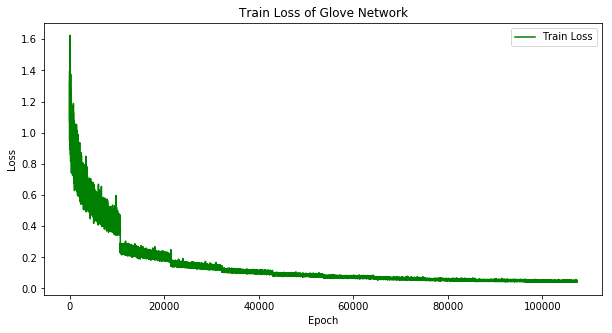

In [13]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Glove Network")
plt.plot(train_losses, label="Train Loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/glove_final_train_loss.png')
plt.show()

## Plot Word Vectors Using PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
embeds_i = glove.wi.weight.cpu().data.numpy()
embeds_j = glove.wj.weight.cpu().data.numpy()
embeds = embeds_i + embeds_j

top_k = 300

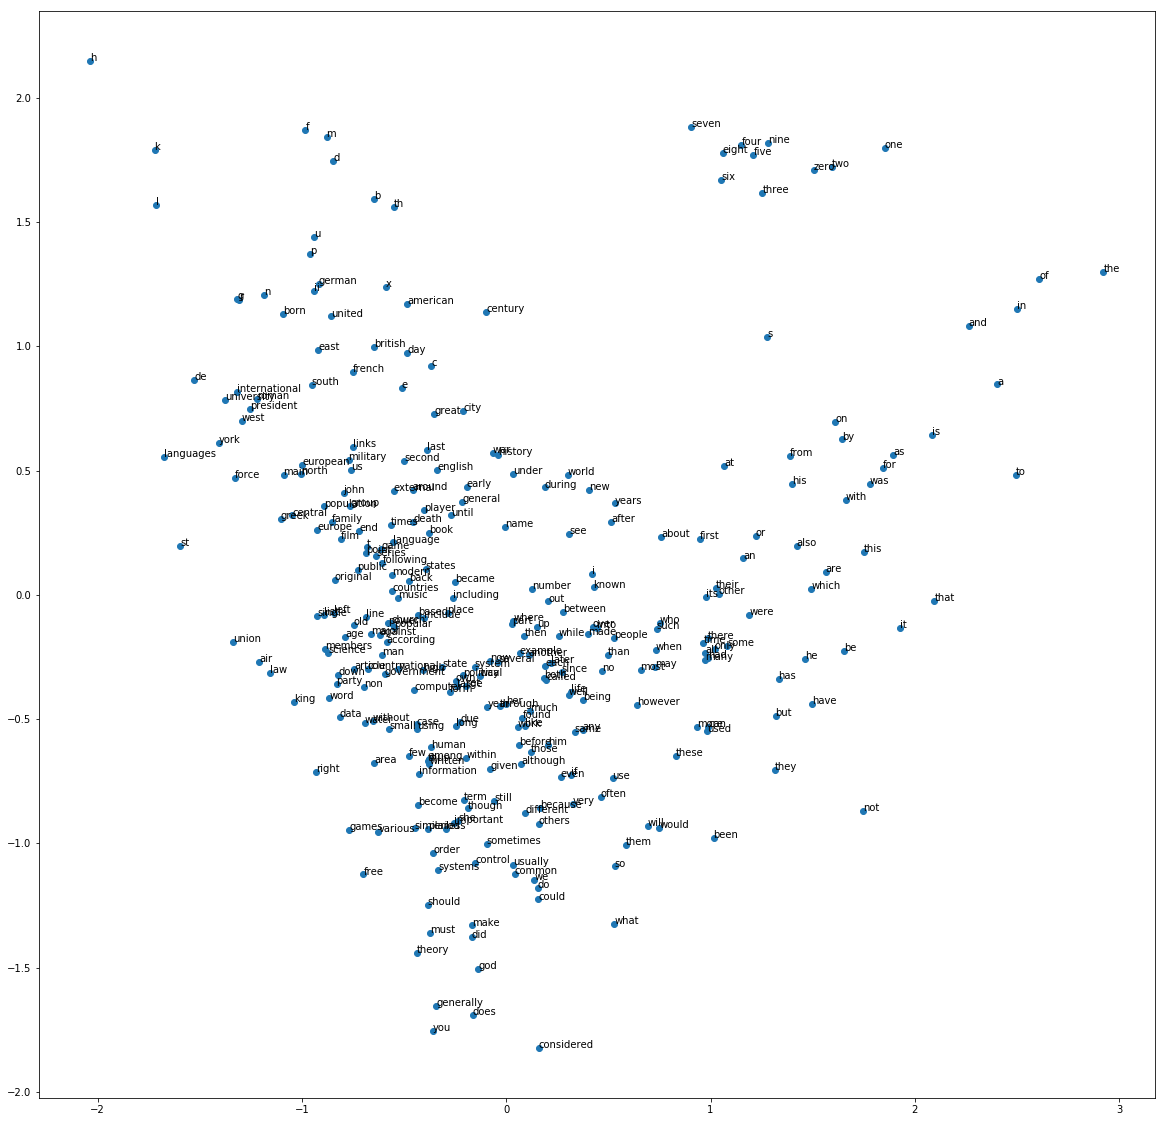

In [16]:
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeds[:top_k, :])

plt.figure(figsize=(20,20))
plt.scatter(embeds_pca[:, 0], embeds_pca[:, 1])
for i in range(top_k):
    plt.annotate(datasets._idx2word[i], xy=(embeds_pca[i, 0], embeds_pca[i, 1]))

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/glove_pca_word_vectors.png')
plt.show()

## Plot Word Vectors Using TSNE

In [17]:
from sklearn.manifold import TSNE

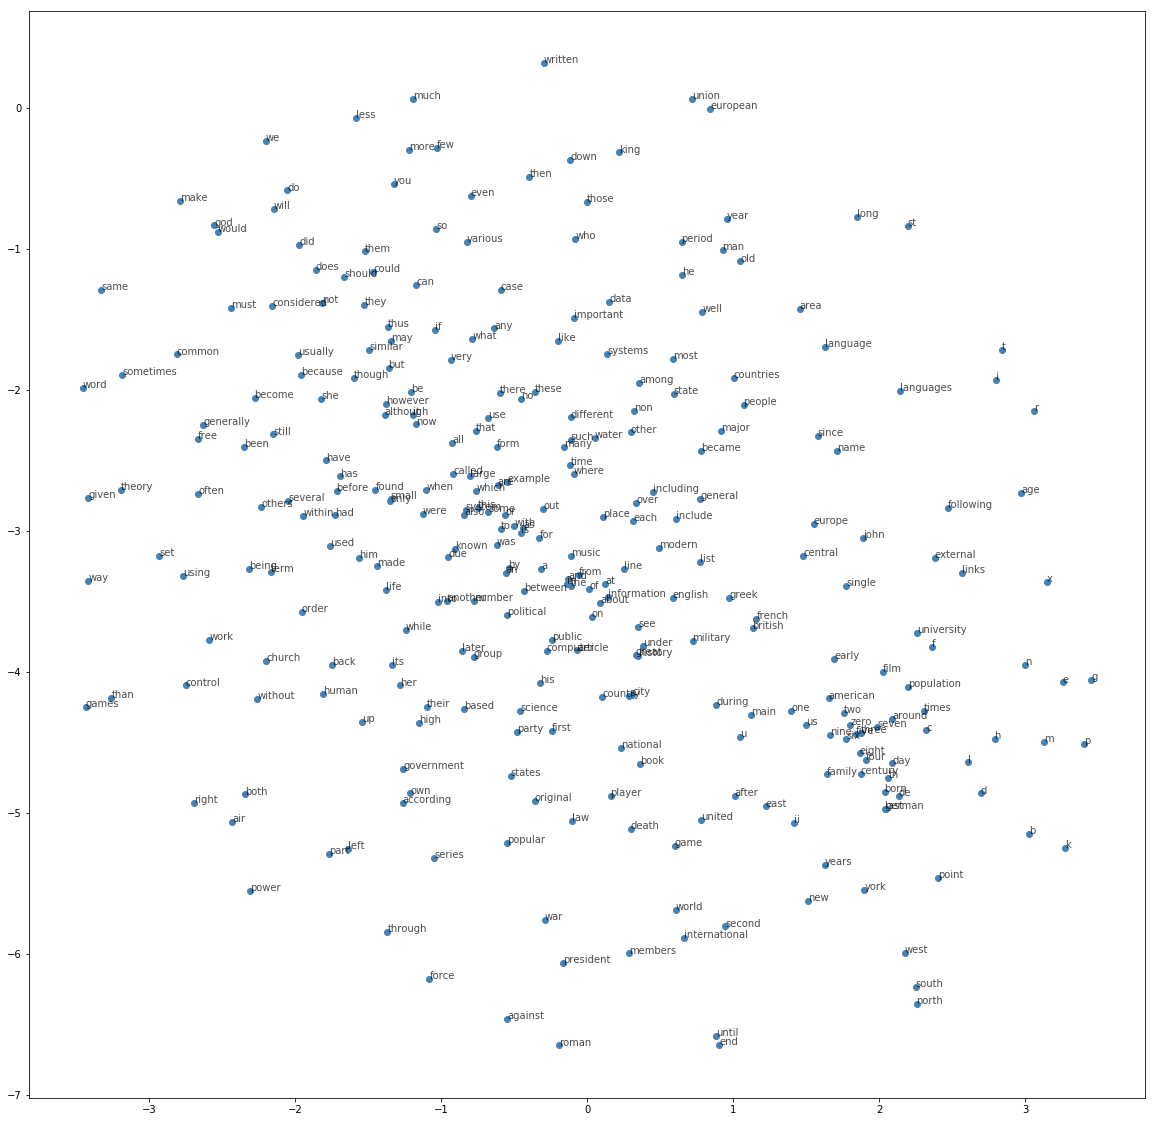

In [18]:
tsne = TSNE(metric='cosine', random_state=9)
embeds_tsne = tsne.fit_transform(embeds[:top_k, :])
fig, ax = plt.subplots(figsize=(20,20))
for idx in range(top_k):
    plt.scatter(*embeds_tsne[idx, :], color='steelblue')
    plt.annotate(datasets._idx2word[idx], (embeds_tsne[idx, 0], embeds_tsne[idx, 1]), alpha=0.7)
    
plt.savefig('./images/glove_tsne_word_vectors.png')
plt.show()

---